# Create Keras Model
CoreMLTools needs a keras model to convert instead of a tensorflow.keras model😒 so this notebook is for creating a keras model.

#### Imports and functions

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [2]:
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras import layers
from keras.models import Sequential
from keras import callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pdb

train_path = '..//data//helen//train_rotated//'
test_path = '..//data//helen//test_rotated//'
num_classes = 4


def plot_figures(figures, nrows=1, ncols=1, size=8):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(size, size))
    for ind, title in enumerate(figures):
        axeslist[ind].imshow(figures[title], cmap=plt.gray())
        axeslist[ind].set_title(title)
        axeslist[ind].set_axis_off()
    plt.tight_layout()  # optional


def plot_train_history(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


x_train = np.load(train_path+'x_train_rotated_bilinear.npy')
y_train = np.load(train_path+'y_train_rotated_bilinear.npy')
x_test = np.load(test_path+'x_test_rotated_bilinear.npy')
y_test = np.load(test_path+'y_test_rotated_bilinear.npy')

# Current Best - VGG (standardized, Adam) - 0.9924 (epoch 67)
Scaling - Standardize (subtract mean pixel value and divide by standard deviation)

Optimizer - Adam

We will use the same model architecture as the previous notebook, 4-Class-CNN. We just want to make sure everything is working as expected and test the speed improvements from using images in RAM

#### Define Train function

In [3]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=18, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, min_lr=1e-9, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt=None, plot_hist='True'):
    if not opt:   # if opt is None,
        opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size, shuffle=True)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size, shuffle=True)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [42]:
model_11 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_11.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_64 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_98 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 124, 124, 24)      3480      
_________________________________________________________________
batch_normalization_65 (Batc (None, 124, 124, 24)      96        
_________________________________________________________________
activation_99 (Activation)   (None, 124, 124, 24)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 11s 167ms/step - loss: 1.6212 - acc: 0.3277 - val_loss: 1.3849 - val_acc: 0.2508
Epoch 2/100
63/63 [==============================] - 6s 93ms/step - loss: 1.1788 - acc: 0.4868 - val_loss: 1.3834 - val_acc: 0.2833
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 0.9728 - acc: 0.6028 - val_loss: 1.3487 - val_acc: 0.3371
Epoch 4/100
63/63 [==============================] - 6s 94ms/step - loss: 0.7689 - acc: 0.6946 - val_loss: 1.2224 - val_acc: 0.5038
Epoch 5/100
63/63 [==============================] - 6s 95ms/step - loss: 0.5795 - acc: 0.7747 - val_loss: 0.8567 - val_acc: 0.6955
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.4451 - acc: 0.8389 - val_loss: 0.4774 - val_acc: 0.8333
Epoch 7/100
63/63 [==============================] - 6s 93ms/step - loss: 0.3595 - acc: 0.8686 - val_loss: 0.3883 - val_acc: 0.8538
Epoch 8/100
63/63 [==============================] - 6s 93ms/step - loss: 

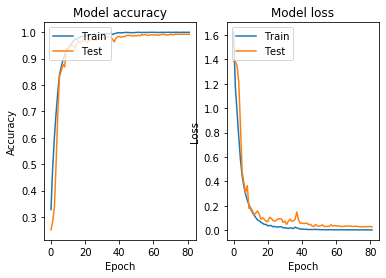

Best val_acc - 0.9924 (epoch 67)


In [43]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_11 = train(model_11, opt=opt)

# New Architectures

## Model 1: Dense(32) - 0.9902 (epoch 36) 158,388
(This is like the original model from `4 Load Images into Memory`)
VGG Model

#### Define Train function

In [9]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [3]:
model_1 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(32),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_1.summary()

W0826 10:53:09.315520  9436 deprecation.py:506] From C:\Users\kendy\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0

#### Execute Training

Epoch 1/100
63/63 [==============================] - 16s 250ms/step - loss: 1.4721 - acc: 0.2600 - val_loss: 1.3703 - val_acc: 0.2773
Epoch 2/100
63/63 [==============================] - 7s 119ms/step - loss: 1.3541 - acc: 0.3052 - val_loss: 1.3794 - val_acc: 0.3197
Epoch 3/100
63/63 [==============================] - 7s 119ms/step - loss: 1.2913 - acc: 0.3901 - val_loss: 1.3439 - val_acc: 0.4136
Epoch 4/100
63/63 [==============================] - 8s 120ms/step - loss: 1.1614 - acc: 0.4839 - val_loss: 1.1680 - val_acc: 0.4795
Epoch 5/100
63/63 [==============================] - 8s 124ms/step - loss: 1.0348 - acc: 0.5996 - val_loss: 1.0209 - val_acc: 0.6333
Epoch 6/100
63/63 [==============================] - 8s 125ms/step - loss: 0.8630 - acc: 0.6926 - val_loss: 0.8800 - val_acc: 0.6848
Epoch 7/100
63/63 [==============================] - 8s 123ms/step - loss: 0.7123 - acc: 0.7659 - val_loss: 0.6868 - val_acc: 0.7985
Epoch 8/100
63/63 [==============================] - 7s 118ms/step -

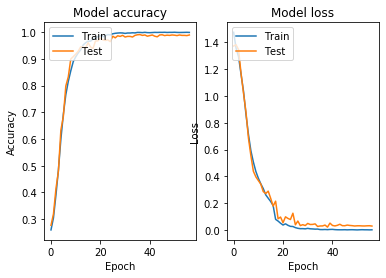

TypeError: unsupported format string passed to list.__format__

In [4]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_1 = train(model_1, opt=opt)

## Model 2: m1 Dense(16) 121,444 - 0.9924 (epoch 38)

#### Define Train function

In [10]:
my_callbacks = [callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, min_lr=1e-6, mode='auto', verbose=1)]

def train(model, epochs=100, initial_epoch=0, batch_size=128, lr=0.01, opt='adadelta', plot_hist='True'):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

#     can test augmentation techniques like brightness and rotation
    train_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    train_generator.fit(x_train)
    train_generator = train_generator.flow(x_train, y_train, seed=11, batch_size=batch_size)
    validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    validation_generator.fit(x_train)
    validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=batch_size)

    history = model.fit_generator(generator=train_generator,
                                  epochs=epochs+initial_epoch,
                                  verbose=1,
                                  callbacks=my_callbacks,
                                  validation_data=validation_generator,
                                  shuffle=True,
                                  initial_epoch=initial_epoch)
    if(plot_hist):
        plot_train_history(history)
                
    index = history.history['val_acc'].index(max(history.history['val_acc']))
    print('Best val_acc - {:.4} (epoch {:})'.format(history.history['val_acc'][index], index+1))
    return history, model

#### Define Model

In [8]:
model_2 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_18 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_24 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 32)      4640      
_________________________________________________________________
batch_normalization_19 (Batc (None, 124, 124, 32)      128       
_________________________________________________________________
activation_25 (Activation)   (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 1.4233 - acc: 0.2592 - val_loss: 1.3828 - val_acc: 0.2402
Epoch 2/100
63/63 [==============================] - 8s 122ms/step - loss: 1.3261 - acc: 0.3520 - val_loss: 1.3801 - val_acc: 0.2932
Epoch 3/100
63/63 [==============================] - 8s 121ms/step - loss: 1.2216 - acc: 0.4397 - val_loss: 1.3407 - val_acc: 0.3553
Epoch 4/100
63/63 [==============================] - 8s 122ms/step - loss: 1.0811 - acc: 0.5635 - val_loss: 1.1925 - val_acc: 0.4970
Epoch 5/100
63/63 [==============================] - 8s 121ms/step - loss: 0.9076 - acc: 0.6690 - val_loss: 1.5090 - val_acc: 0.4295
Epoch 6/100
63/63 [==============================] - 8s 125ms/step - loss: 0.7487 - acc: 0.7620 - val_loss: 1.2725 - val_acc: 0.5432
Epoch 7/100
63/63 [==============================] - 8s 128ms/step - loss: 0.6128 - acc: 0.8216 - val_loss: 1.2474 - val_acc: 0.6106
Epoch 8/100
63/63 [==============================] - 8s 123ms/step -

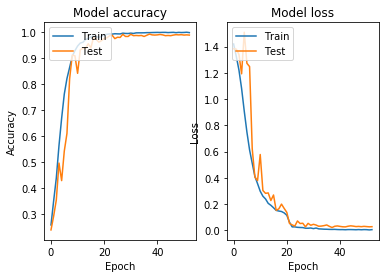

Best val_acc - 0.9924 (epoch 38)


In [9]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_2 = train(model_2, opt=opt)

## Model 3: m2 filter size shrink 75,044 - 0.9917 (epoch 43)
Take the past model and make it smaller.

#### Define Model

In [16]:
model_3 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
activation_8 (Activation)    (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)       

#### Execute Training

Epoch 1/100
63/63 [==============================] - 8s 133ms/step - loss: 1.4150 - acc: 0.2615 - val_loss: 1.3683 - val_acc: 0.2955
Epoch 2/100
63/63 [==============================] - 6s 98ms/step - loss: 1.3409 - acc: 0.3086 - val_loss: 1.3477 - val_acc: 0.2947
Epoch 3/100
63/63 [==============================] - 6s 98ms/step - loss: 1.2459 - acc: 0.3695 - val_loss: 1.2906 - val_acc: 0.3462
Epoch 4/100
63/63 [==============================] - 6s 98ms/step - loss: 1.0511 - acc: 0.4706 - val_loss: 0.9954 - val_acc: 0.5235
Epoch 5/100
63/63 [==============================] - 6s 98ms/step - loss: 0.8809 - acc: 0.5567 - val_loss: 0.7963 - val_acc: 0.6205
Epoch 6/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6612 - acc: 0.7168 - val_loss: 0.5668 - val_acc: 0.7636
Epoch 7/100
63/63 [==============================] - 6s 98ms/step - loss: 0.5130 - acc: 0.7871 - val_loss: 0.4516 - val_acc: 0.8205
Epoch 8/100
63/63 [==============================] - 6s 98ms/step - loss: 0

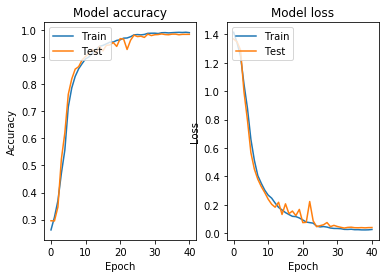

Best val_acc - 0.9871 (epoch 33)


In [17]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_3 = train(model_3, opt=opt)

#### Predict validation set
Everything looks good. The predictions sum to one and it is predicting the correct class

W0903 13:34:24.179629 10560 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


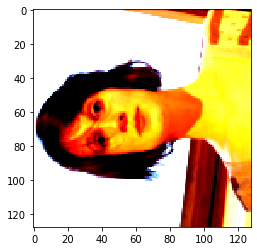

In [38]:
batchx, batchy = validation_generator.next()
plt.imshow(batchx[3])

In [44]:
batchx_pred = model_3.predict(batchx)
batchx_pred.shape

(128, 4)

In [47]:
batchx_pred[3].argmax()

3

W0903 13:40:08.598204 10560 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


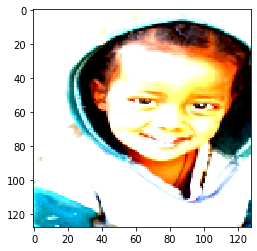

In [48]:
plt.imshow(batchx[0])

In [51]:
batchx_pred[0]

array([9.9954468e-01, 3.8588532e-09, 4.5532439e-04, 5.4802951e-15],
      dtype=float32)

In [49]:
batchx_pred[0].argmax()

0

In [50]:
batchx_pred[0].sum()

1.0

## Model 4: m3 less filters 45,026 - 


#### Define Model

In [3]:
model_4 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_4.summary()

W0903 12:53:53.072096 10560 deprecation.py:506] From C:\Users\kendy\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 20)      80        
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 20)        0

#### Execute Training

Epoch 1/100
63/63 [==============================] - 13s 200ms/step - loss: 3.2866 - acc: 0.2499 - val_loss: 1.3872 - val_acc: 0.2500
Epoch 2/100
63/63 [==============================] - 5s 81ms/step - loss: 1.3887 - acc: 0.2403 - val_loss: 1.3900 - val_acc: 0.2500
Epoch 3/100
63/63 [==============================] - 5s 80ms/step - loss: 1.3890 - acc: 0.2477 - val_loss: 1.3882 - val_acc: 0.2500
Epoch 4/100
62/63 [============================>.] - ETA: 0s - loss: 1.3884 - acc: 0.2459
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
63/63 [==============================] - 5s 81ms/step - loss: 1.3885 - acc: 0.2457 - val_loss: 1.3878 - val_acc: 0.2500
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 1.3878 - acc: 0.2529 - val_loss: 1.3886 - val_acc: 0.2500
Epoch 6/100
63/63 [==============================] - 5s 82ms/step - loss: 1.3885 - acc: 0.2439 - val_loss: 1.3889 - val_acc: 0.2500
Epoch 7/100
62/63 [============================>.]

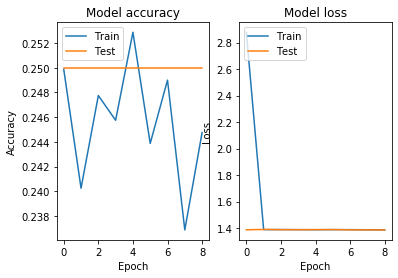

Best val_acc - 0.25 (epoch 1)


In [4]:
opt = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_4 = train(model_4, opt=opt)

Something isn't right. Lets [debug](https://stackoverflow.com/questions/43674411/training-and-loss-not-changing-in-keras-cnn-model)

1. Get the counts of each class in predictions and check if it's predicting all one class.

In [13]:
validation_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
validation_generator.fit(x_train)
validation_generator = validation_generator.flow(x_test, y_test, seed=11, batch_size=128)
preds = model_4.predict(validation_generator)

In [14]:
preds.shape

(1320, 4)

In [15]:
preds[0]

array([0.25195855, 0.23209201, 0.25229964, 0.2636498 ], dtype=float32)

In [52]:
preds[1]

array([0.25195855, 0.23209201, 0.25229964, 0.2636498 ], dtype=float32)

In [53]:
preds[2]

array([0.25195855, 0.23209201, 0.25229964, 0.2636498 ], dtype=float32)

So its predicting the exact same probabilities for every prediction..

## Model 5: m4 reduce learning rate 58,880 - 0.9447 (epoch 214?)
The [stackoverflow page](https://stackoverflow.com/questions/43674411/training-and-loss-not-changing-in-keras-cnn-model) recommends reducing the learning rate by a factor of ten.

#### Define Model

In [74]:
model_5 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_54 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_72 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_55 (Batc (None, 124, 124, 20)      80        
_________________________________________________________________
activation_73 (Activation)   (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 62, 62, 20)       

#### Execute Training

Epoch 1/200
63/63 [==============================] - 8s 133ms/step - loss: 1.5054 - acc: 0.2522 - val_loss: 1.3837 - val_acc: 0.3182
Epoch 2/200
63/63 [==============================] - 5s 81ms/step - loss: 1.3894 - acc: 0.2548 - val_loss: 1.3827 - val_acc: 0.3129
Epoch 3/200
63/63 [==============================] - 5s 81ms/step - loss: 1.3873 - acc: 0.2569 - val_loss: 1.3820 - val_acc: 0.2955
Epoch 4/200
63/63 [==============================] - 5s 81ms/step - loss: 1.3863 - acc: 0.2571 - val_loss: 1.3832 - val_acc: 0.2970
Epoch 5/200
63/63 [==============================] - 5s 81ms/step - loss: 1.3862 - acc: 0.2595 - val_loss: 1.3849 - val_acc: 0.2780
Epoch 6/200
62/63 [============================>.] - ETA: 0s - loss: 1.3809 - acc: 0.2698
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
63/63 [==============================] - 6s 90ms/step - loss: 1.3811 - acc: 0.2685 - val_loss: 1.3845 - val_acc: 0.2780
Epoch 7/200
63/63 [==============================

Epoch 119/200
62/63 [============================>.] - ETA: 0s - loss: 0.2693 - acc: 0.9060
Epoch 00119: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
63/63 [==============================] - 5s 81ms/step - loss: 0.2697 - acc: 0.9062 - val_loss: 0.2624 - val_acc: 0.9098
Epoch 120/200
63/63 [==============================] - 5s 81ms/step - loss: 0.2695 - acc: 0.9046 - val_loss: 0.2616 - val_acc: 0.9114
Epoch 121/200
63/63 [==============================] - 5s 81ms/step - loss: 0.2698 - acc: 0.9007 - val_loss: 0.2620 - val_acc: 0.9114
Epoch 122/200
63/63 [==============================] - 5s 81ms/step - loss: 0.2659 - acc: 0.9057 - val_loss: 0.2618 - val_acc: 0.9091
Epoch 123/200
63/63 [==============================] - 5s 81ms/step - loss: 0.2715 - acc: 0.9011 - val_loss: 0.2622 - val_acc: 0.9091
Epoch 124/200
62/63 [============================>.] - ETA: 0s - loss: 0.2702 - acc: 0.9038
Epoch 00124: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
63

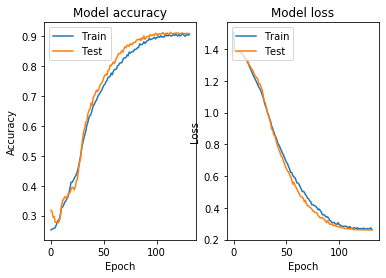

Best val_acc - 0.9136 (epoch 114)


In [75]:
# lower the learning rate by a factor of 10
history, model_5 = train(model_5, lr=0.0001, epochs=200)

Epoch 134/233
63/63 [==============================] - 8s 133ms/step - loss: 0.2793 - acc: 0.9034 - val_loss: 0.2394 - val_acc: 0.9182
Epoch 135/233
63/63 [==============================] - 5s 80ms/step - loss: 0.2807 - acc: 0.8972 - val_loss: 0.2422 - val_acc: 0.9182
Epoch 136/233
63/63 [==============================] - 5s 80ms/step - loss: 0.2620 - acc: 0.9086 - val_loss: 0.2543 - val_acc: 0.9144
Epoch 137/233
63/63 [==============================] - 5s 80ms/step - loss: 0.2635 - acc: 0.9071 - val_loss: 0.2434 - val_acc: 0.9121
Epoch 138/233
63/63 [==============================] - 5s 81ms/step - loss: 0.2510 - acc: 0.9107 - val_loss: 0.2497 - val_acc: 0.9098
Epoch 139/233
62/63 [============================>.] - ETA: 0s - loss: 0.2490 - acc: 0.9112
Epoch 00139: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
63/63 [==============================] - 6s 90ms/step - loss: 0.2484 - acc: 0.9115 - val_loss: 0.2495 - val_acc: 0.9152
Epoch 140/233
63/63 [================

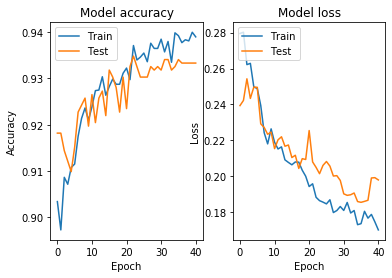

Best val_acc - 0.9348 (epoch 23)


In [77]:
# more training
history, model_5 = train(model_5, lr=0.0001, initial_epoch=133)

In [78]:
model_5.save('..//models//7 Shrinkit m5 174 epochs.h5')

Epoch 176/275
63/63 [==============================] - 8s 133ms/step - loss: 0.1951 - acc: 0.9291 - val_loss: 0.1982 - val_acc: 0.9242
Epoch 177/275
63/63 [==============================] - 5s 83ms/step - loss: 0.1881 - acc: 0.9375 - val_loss: 0.1967 - val_acc: 0.9273
Epoch 178/275
63/63 [==============================] - 5s 83ms/step - loss: 0.1850 - acc: 0.9352 - val_loss: 0.1940 - val_acc: 0.9303
Epoch 179/275
63/63 [==============================] - 5s 80ms/step - loss: 0.1812 - acc: 0.9373 - val_loss: 0.1986 - val_acc: 0.9242
Epoch 180/275
63/63 [==============================] - 5s 81ms/step - loss: 0.1727 - acc: 0.9429 - val_loss: 0.1988 - val_acc: 0.9235
Epoch 181/275
63/63 [==============================] - 5s 80ms/step - loss: 0.1701 - acc: 0.9364 - val_loss: 0.1879 - val_acc: 0.9280
Epoch 182/275
63/63 [==============================] - 5s 81ms/step - loss: 0.1680 - acc: 0.9406 - val_loss: 0.1709 - val_acc: 0.9371
Epoch 183/275
63/63 [==============================] - 5s 84m

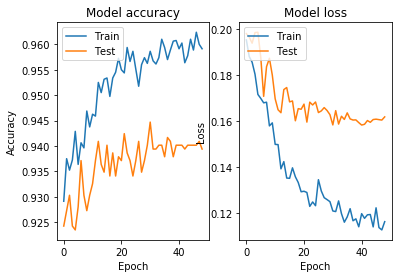

Best val_acc - 0.9447 (epoch 31)


In [79]:
# more training
history, model_5 = train(model_5, lr=0.0001, initial_epoch=175)

## Model 6: m5 add layers 33,512 - 0.9652 (epoch 167)
m5 but add a segment

#### Define Model

In [4]:
model_6 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(20, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(20, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(16),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_6.summary()

W0906 14:45:58.225801  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 14:45:58.241759  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 14:45:58.273673  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 14:45:58.340892  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instea

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 20)      2900      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 20)      80        
_________________________________________________________________
activation_2 (Activation)    (None, 124, 124, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 20)       

#### Execute Training

W0906 14:46:08.168560  8664 deprecation_wrapper.py:119] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0906 14:46:27.730760  8664 deprecation.py:323] From C:\Users\kendy\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
63/63 [==============================] - 9s 136ms/step - loss: 1.9528 - acc: 0.2542 - val_loss: 1.3934 - val_acc: 0.2856
Epoch 2/100
63/63 [==============================] - 5s 80ms/step - loss: 1.6521 - acc: 0.2716 - val_loss: 1.3732 - val_acc: 0.3152
Epoch 3/100
63/63 [==============================] - 5s 81ms/step - loss: 1.5294 - acc: 0.2847 - val_loss: 1.3702 - val_acc: 0.3311
Epoch 4/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4647 - acc: 0.2822 - val_loss: 1.3744 - val_acc: 0.3288
Epoch 5/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4271 - acc: 0.2954 - val_loss: 1.3774 - val_acc: 0.3023
Epoch 6/100
63/63 [==============================] - 5s 80ms/step - loss: 1.4067 - acc: 0.2934 - val_loss: 1.3784 - val_acc: 0.3008
Epoch 7/100
63/63 [==============================] - 5s 80ms/step - loss: 1.3981 - acc: 0.2844 - val_loss: 1.3768 - val_acc: 0.2917
Epoch 8/100
63/63 [==============================] - 5s 80ms/step - loss: 1

63/63 [==============================] - 5s 78ms/step - loss: 1.1164 - acc: 0.5053 - val_loss: 1.0416 - val_acc: 0.5811
Epoch 62/100
63/63 [==============================] - 5s 78ms/step - loss: 1.1138 - acc: 0.5038 - val_loss: 1.0419 - val_acc: 0.5811
Epoch 63/100
63/63 [==============================] - 5s 78ms/step - loss: 1.1031 - acc: 0.5219 - val_loss: 1.0269 - val_acc: 0.5864
Epoch 64/100
63/63 [==============================] - 5s 78ms/step - loss: 1.0903 - acc: 0.5252 - val_loss: 1.0263 - val_acc: 0.6000
Epoch 65/100
63/63 [==============================] - 5s 79ms/step - loss: 1.0858 - acc: 0.5256 - val_loss: 1.0056 - val_acc: 0.5970
Epoch 66/100
63/63 [==============================] - 5s 78ms/step - loss: 1.0880 - acc: 0.5316 - val_loss: 0.9945 - val_acc: 0.5985
Epoch 67/100
63/63 [==============================] - 5s 78ms/step - loss: 1.0709 - acc: 0.5391 - val_loss: 0.9877 - val_acc: 0.6053
Epoch 68/100
63/63 [==============================] - 5s 79ms/step - loss: 1.0675 

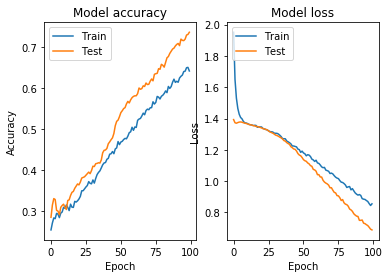

Best val_acc - 0.7356 (epoch 100)


In [5]:
# lower the learning rate by a factor of 10
history, model_6 = train(model_6, lr=0.0001)

Epoch 102/201
63/63 [==============================] - 6s 102ms/step - loss: 0.8329 - acc: 0.6550 - val_loss: 0.6780 - val_acc: 0.7311
Epoch 103/201
63/63 [==============================] - 5s 79ms/step - loss: 0.8170 - acc: 0.6621 - val_loss: 0.6384 - val_acc: 0.7598
Epoch 104/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7724 - acc: 0.6827 - val_loss: 0.6317 - val_acc: 0.7591
Epoch 105/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7664 - acc: 0.6902 - val_loss: 0.5923 - val_acc: 0.7795
Epoch 106/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7426 - acc: 0.6983 - val_loss: 0.5640 - val_acc: 0.7894
Epoch 107/201
63/63 [==============================] - 5s 79ms/step - loss: 0.7045 - acc: 0.7102 - val_loss: 0.5599 - val_acc: 0.7795
Epoch 108/201
63/63 [==============================] - 5s 79ms/step - loss: 0.6800 - acc: 0.7290 - val_loss: 0.5261 - val_acc: 0.8023
Epoch 109/201
63/63 [==============================] - 5s 79m

63/63 [==============================] - 5s 79ms/step - loss: 0.1685 - acc: 0.9412 - val_loss: 0.1232 - val_acc: 0.9598
Epoch 163/201
63/63 [==============================] - 5s 79ms/step - loss: 0.1669 - acc: 0.9420 - val_loss: 0.1231 - val_acc: 0.9591

Epoch 00163: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 164/201
63/63 [==============================] - 5s 80ms/step - loss: 0.1692 - acc: 0.9389 - val_loss: 0.1234 - val_acc: 0.9629
Epoch 165/201
63/63 [==============================] - 5s 80ms/step - loss: 0.1666 - acc: 0.9399 - val_loss: 0.1246 - val_acc: 0.9621
Epoch 166/201
63/63 [==============================] - 5s 79ms/step - loss: 0.1655 - acc: 0.9396 - val_loss: 0.1244 - val_acc: 0.9629
Epoch 167/201
63/63 [==============================] - 5s 80ms/step - loss: 0.1658 - acc: 0.9369 - val_loss: 0.1246 - val_acc: 0.9614
Epoch 168/201
63/63 [==============================] - 5s 80ms/step - loss: 0.1639 - acc: 0.9387 - val_loss: 0.1227 - val_acc: 0.

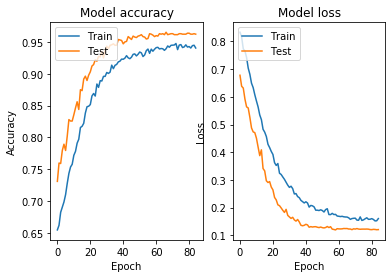

Best val_acc - 0.9652 (epoch 67)


In [6]:
history, model_6 = train(model_6, initial_epoch=101, lr=0.0001)

In [7]:
# save with the convention 'm[model number]_[# parameters]_[best val_acc].h5'
model_6.save('..//models//m6_33512_9652.h5')

## Model 7: m6 Dense(512)  - 0.9811 (epoch 39)
reduce

#### Define Model

In [31]:
model_7 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_7.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_34 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_58 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_35 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_59 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 7s 110ms/step - loss: 2.0198 - acc: 0.3190 - val_loss: 1.3667 - val_acc: 0.3189
Epoch 2/100
63/63 [==============================] - 5s 72ms/step - loss: 1.2386 - acc: 0.4505 - val_loss: 1.4645 - val_acc: 0.2515
Epoch 3/100
63/63 [==============================] - 5s 73ms/step - loss: 1.0747 - acc: 0.5479 - val_loss: 1.3424 - val_acc: 0.3500
Epoch 4/100
63/63 [==============================] - 5s 73ms/step - loss: 0.8556 - acc: 0.6596 - val_loss: 1.1422 - val_acc: 0.4977ss - ETA: 0s - loss: 0.8618 - acc: 0.6
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6883 - acc: 0.7335 - val_loss: 0.9972 - val_acc: 0.6053
Epoch 6/100
63/63 [==============================] - 4s 71ms/step - loss: 0.5731 - acc: 0.7819 - val_loss: 0.7295 - val_acc: 0.7477
Epoch 7/100
63/63 [==============================] - 5s 74ms/step - loss: 0.4515 - acc: 0.8265 - val_loss: 0.4841 - val_acc: 0.8174
Epoch 8/100
63/63 [==================

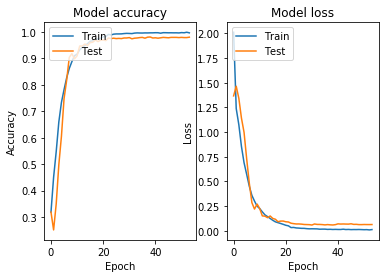

Best val_acc - 0.9811 (epoch 39)


In [32]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_7 = train(model_7, opt=opt)

## Model 8: m7 Dense(256) - 0.9606 (epoch 33)
reduce

#### Define Model

In [35]:
model_8 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_8.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_46 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_74 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_47 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_75 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 7s 115ms/step - loss: 1.7864 - acc: 0.3383 - val_loss: 1.3855 - val_acc: 0.2530
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 1.2013 - acc: 0.4888 - val_loss: 1.3683 - val_acc: 0.3758
Epoch 3/100
63/63 [==============================] - 5s 74ms/step - loss: 1.0466 - acc: 0.5760 - val_loss: 1.3054 - val_acc: 0.3780
Epoch 4/100
63/63 [==============================] - 4s 71ms/step - loss: 0.8540 - acc: 0.6609 - val_loss: 1.2623 - val_acc: 0.4045
Epoch 5/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6987 - acc: 0.7259 - val_loss: 1.0066 - val_acc: 0.5818
Epoch 6/100
63/63 [==============================] - 5s 72ms/step - loss: 0.5949 - acc: 0.7697 - val_loss: 1.0184 - val_acc: 0.5667
Epoch 7/100
63/63 [==============================] - 5s 72ms/step - loss: 0.5340 - acc: 0.7946 - val_loss: 0.8003 - val_acc: 0.6765
Epoch 8/100
63/63 [==============================] - 5s 72ms/step - loss: 0

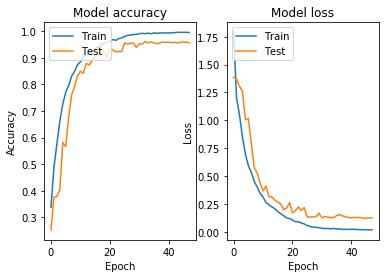

Best val_acc - 0.9606 (epoch 33)


In [36]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_8 = train(model_8, opt=opt)

## Model 9: m8 - more filters - 0.9902 (epoch 42)
Maybe more filters will work better this time.

You bet your ass it does 😎

#### Define Model

In [37]:
model_9 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_9.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_52 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_82 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_53 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_83 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 2.0371 - acc: 0.2744 - val_loss: 1.3728 - val_acc: 0.3326
Epoch 2/100
63/63 [==============================] - 5s 77ms/step - loss: 1.3371 - acc: 0.3546 - val_loss: 1.3690 - val_acc: 0.3364
Epoch 3/100
63/63 [==============================] - 5s 77ms/step - loss: 1.2082 - acc: 0.4660 - val_loss: 1.3647 - val_acc: 0.3258
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.9578 - acc: 0.6127 - val_loss: 1.3419 - val_acc: 0.3455
Epoch 5/100
63/63 [==============================] - 5s 75ms/step - loss: 0.7645 - acc: 0.7014 - val_loss: 1.1181 - val_acc: 0.5439
Epoch 6/100
63/63 [==============================] - 5s 79ms/step - loss: 0.6213 - acc: 0.7605 - val_loss: 0.8408 - val_acc: 0.6591
Epoch 7/100
63/63 [==============================] - 5s 77ms/step - loss: 0.4846 - acc: 0.8169 - val_loss: 0.4267 - val_acc: 0.8591
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 

Epoch 55/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0327 - val_acc: 0.9879
Epoch 56/100
63/63 [==============================] - 5s 75ms/step - loss: 0.0111 - acc: 0.9970 - val_loss: 0.0392 - val_acc: 0.9879
Epoch 57/100
63/63 [==============================] - 5s 83ms/step - loss: 0.0126 - acc: 0.9967 - val_loss: 0.0333 - val_acc: 0.9879
Epoch 00057: early stopping


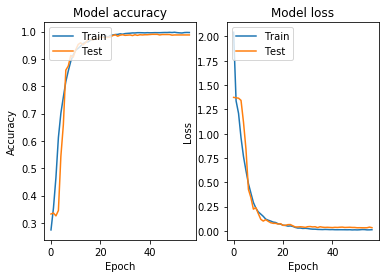

Best val_acc - 0.9902 (epoch 42)


In [38]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_9 = train(model_9, opt=opt)

## Model 10: m9 - Dense(128) - 0.9674 (epoch 40)
Repeat the above process

#### Define Model

In [39]:
model_10 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_10.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_58 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_90 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
batch_normalization_59 (Batc (None, 124, 124, 16)      64        
_________________________________________________________________
activation_91 (Activation)   (None, 124, 124, 16)      0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 16)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 17s 264ms/step - loss: 1.5746 - acc: 0.3274 - val_loss: 1.3821 - val_acc: 0.2682
Epoch 2/100
63/63 [==============================] - 5s 81ms/step - loss: 1.2563 - acc: 0.4426 - val_loss: 1.3841 - val_acc: 0.2568
Epoch 3/100
63/63 [==============================] - 5s 86ms/step - loss: 1.0891 - acc: 0.5520 - val_loss: 1.3375 - val_acc: 0.3333
Epoch 4/100
63/63 [==============================] - 5s 85ms/step - loss: 0.9035 - acc: 0.6436 - val_loss: 1.1219 - val_acc: 0.5576
Epoch 5/100
63/63 [==============================] - 5s 81ms/step - loss: 0.7165 - acc: 0.7245 - val_loss: 0.7702 - val_acc: 0.7061
Epoch 6/100
63/63 [==============================] - 5s 82ms/step - loss: 0.6035 - acc: 0.7715 - val_loss: 0.5510 - val_acc: 0.8061
Epoch 7/100
63/63 [==============================] - 5s 81ms/step - loss: 0.5114 - acc: 0.8067 - val_loss: 0.4951 - val_acc: 0.8371
Epoch 8/100
63/63 [==============================] - 5s 79ms/step - loss: 

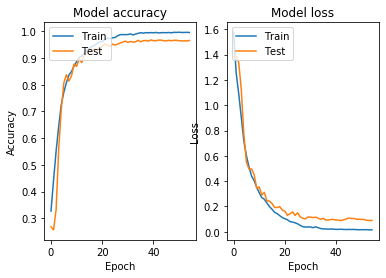

Best val_acc - 0.9674 (epoch 40)


In [41]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_10 = train(model_10, opt=opt)

## Model 11: m10 - more filters  - 0.9924 (epoch 67)
Repeat the above process

#### Define Model

In [42]:
model_11 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_11.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_64 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_98 (Activation)   (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 124, 124, 24)      3480      
_________________________________________________________________
batch_normalization_65 (Batc (None, 124, 124, 24)      96        
_________________________________________________________________
activation_99 (Activation)   (None, 124, 124, 24)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 11s 167ms/step - loss: 1.6212 - acc: 0.3277 - val_loss: 1.3849 - val_acc: 0.2508
Epoch 2/100
63/63 [==============================] - 6s 93ms/step - loss: 1.1788 - acc: 0.4868 - val_loss: 1.3834 - val_acc: 0.2833
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 0.9728 - acc: 0.6028 - val_loss: 1.3487 - val_acc: 0.3371
Epoch 4/100
63/63 [==============================] - 6s 94ms/step - loss: 0.7689 - acc: 0.6946 - val_loss: 1.2224 - val_acc: 0.5038
Epoch 5/100
63/63 [==============================] - 6s 95ms/step - loss: 0.5795 - acc: 0.7747 - val_loss: 0.8567 - val_acc: 0.6955
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.4451 - acc: 0.8389 - val_loss: 0.4774 - val_acc: 0.8333
Epoch 7/100
63/63 [==============================] - 6s 93ms/step - loss: 0.3595 - acc: 0.8686 - val_loss: 0.3883 - val_acc: 0.8538
Epoch 8/100
63/63 [==============================] - 6s 93ms/step - loss: 

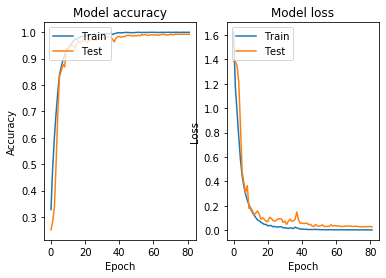

Best val_acc - 0.9924 (epoch 67)


In [43]:
history, model_11 = train(model_11, opt=opt)

## Model 12: m11 - Dense(32)  - 0.9871 (epoch 39)
Repeat the above process

#### Define Model

In [48]:
model_12 = Sequential([
    Conv2D(16, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(24, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(24, (3, 3), strides=(1, 1), input_shape=(128, 128, 3), data_format="channels_last", padding='valid'),   # RGB
    BatchNormalization(),
    Activation('relu'),
    Conv2D(16, (3, 3), strides=(1, 1), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(32),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
])
model_12.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization_88 (Batc (None, 126, 126, 16)      64        
_________________________________________________________________
activation_130 (Activation)  (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 124, 124, 24)      3480      
_________________________________________________________________
batch_normalization_89 (Batc (None, 124, 124, 24)      96        
_________________________________________________________________
activation_131 (Activation)  (None, 124, 124, 24)      0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 62, 62, 24)      

#### Execute Training

Epoch 1/100
63/63 [==============================] - 10s 154ms/step - loss: 1.4503 - acc: 0.2505 - val_loss: 1.3859 - val_acc: 0.2515
Epoch 2/100
63/63 [==============================] - 6s 94ms/step - loss: 1.3516 - acc: 0.3114 - val_loss: 1.3647 - val_acc: 0.2515
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 1.1655 - acc: 0.4499 - val_loss: 1.2365 - val_acc: 0.3886
Epoch 4/100
63/63 [==============================] - 6s 95ms/step - loss: 0.9368 - acc: 0.5886 - val_loss: 1.0630 - val_acc: 0.5341
Epoch 5/100
63/63 [==============================] - 6s 98ms/step - loss: 0.7255 - acc: 0.7056 - val_loss: 0.7613 - val_acc: 0.6955
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.5441 - acc: 0.7866 - val_loss: 0.5096 - val_acc: 0.8038
Epoch 7/100
63/63 [==============================] - 6s 97ms/step - loss: 0.4457 - acc: 0.8269 - val_loss: 0.3409 - val_acc: 0.8773
Epoch 8/100
63/63 [==============================] - 6s 95ms/step - loss: 

Epoch 00054: early stopping


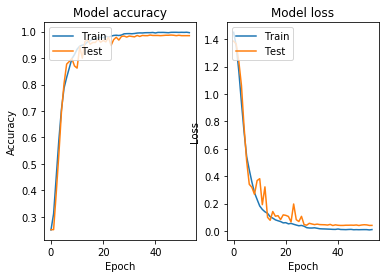

Best val_acc - 0.9871 (epoch 39)


In [49]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
history, model_12 = train(model_12, opt=opt)

# Results
The fastest optimizer was Adam, achieving a val_acc of 0.9682 at epoch 28.
The best performing optimizer is also Adam, with a val_acc of 0.9697 at epoch 56 :)